In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt 
while not os.getcwd().endswith('-analysis'): os.chdir('..')

from sklearn.metrics import accuracy_score
from sklearn.utils import resample

## Bootstrap 
Refer to [guide](https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html).
Thanks to ronaldo issues; I face the following situation: 

- `all_model_predictions-0.csv` contains the predictions for each `split-0` model (aggregated into one csv). 
- `intermediate/pred_<model>` contains the predictions for the remaining `split-[1,2,3,4]`, each as one csv. 

- `bootstrapped_scores.csv` contains partial bootstrap; may need to rerun if we cannot be bothered to figure out which models have ran and only run those again. It's a pain. 
- `bootstrapped_scores-0.csv` contains the bootstraps for each `split-0` model. 

So, we first need to figure out whether we have all model predictions. 
Then, we can bootstrap them and create our 10'000 samples per model. 
Then, we can aggregate them with alternating rows to capture variance from model initialisation. 

In [2]:
from tqdm.contrib.concurrent import thread_map
res_dir = 'notebooks/paper/results'

preds_0 = pd.read_csv(os.path.join(res_dir, 'all_model_predictions-0.csv')) # split_0
dfs = thread_map(
    lambda pred_file: pd.read_csv(
        os.path.join(res_dir, 'intermediate', pred_file), 
        index_col=0
    ), 
    [pred_file for pred_file in os.listdir(os.path.join(res_dir, 'intermediate')) \
     if pred_file.startswith('pred')],
    max_workers=32,
)
preds = pd.concat(dfs, axis=1)
print(preds.shape)

  0%|          | 0/320 [00:00<?, ?it/s]

(22438, 320)


In [3]:
def get_uniq_names(df: pd.DataFrame): 
    ''' get the unique names by removing any suffixes '''
    runs = df.columns

    func = lambda run_name: '-'.join(run_name.split('-')[:-1]) 
    uniq_runs = set([func(run_name) for run_name in runs])
    uniq_runs = {k: 0 for k in uniq_runs}

    for run_name in runs: 
        if func(run_name).strip() == '':
            print(f'empty name: {run_name}')
        uniq_runs[func(run_name)] += 1

    print('unique models:', len(uniq_runs))
    for k, v in uniq_runs.items(): 
        if v == 5: continue
        print(f'removing {v}, {k}')
    
    # keep only the uniq runs in the dataframe
    return df[[run_name for run_name in runs if func(run_name) in uniq_runs]]

logres_preds = pd.read_parquet('notebooks/paper/results/logres_preds.parquet')
all_preds = pd.concat([logres_preds, preds, preds_0], axis=1)
print(all_preds.shape)

all_preds = get_uniq_names(all_preds)

(22438, 484)
empty name: ground_truth
empty name: Unnamed: 0
empty name: ground_truth
unique models: 98
removing 3, 
removing 1, 13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD--proj-reinit)-2e-05lr-


In [4]:
from util import get_contextual_query_data 
query_data = get_contextual_query_data()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


positive_contextual:   0%|          | 0/66465 [00:00<?, ?it/s]

negative_contextual:   0%|          | 0/157913 [00:00<?, ?it/s]

	distribution 		train 	eval 	test 
	unbalanced       	179502 	22438 	22438
	classes          	106714 	13118 	13098
	subclasses       	13864 	 1772 	 1724
	biased           	10398 	 1329 	 1293
	oversampled      	252290 	31758 	31778
	oversampled_biased 	378435 	47637 	47667





In [5]:
x_test = query_data['unbalanced']['X_test']
labels = ['man' if q.is_manually_invoked() else 'auto acc' if q.is_accepted() else 'auto rej'
          for q in x_test] 
all_preds['label'] = labels
# merge ground truth columns if there are multiple 

preds = all_preds.T.copy() 

In [6]:
# convert all preds to boolean for consistency
preds = preds.map(lambda x: int(x) if isinstance(x, (bool, float)) else x)
print(preds.shape)
preds.iloc[:, :10]

preds.to_pickle('notebooks/paper/results/all_preds.pickel')

(487, 22438)


#### Creating Samples 
The four sub-classes are `man acc`, `man rej`, `auto acc`, and `auto rej`. All except for `auto rej` are positive (1 or True). Labels are in the `label` row; ground truth in the `ground_truth` row. Let's merge `man acc` and `man rej`, considering them as one sub-class. 

In [18]:
bootstrap_dir = 'notebooks/paper/results/bootstrap/'
os.makedirs(bootstrap_dir, exist_ok=True)

# get the models: index without the 'label' and 'ground_truth' rows 
labels = preds.loc['label'].to_numpy()
ground_truth = preds.loc['ground_truth'].to_numpy().astype(int)
models = preds.drop(['label', 'ground_truth'], axis=0).index
subclasses = ['man', 'auto acc', 'auto rej']

seed = 42 
n_samples = 10_000
sample_size = preds.shape[1]

print(f'Bootstrapping {n_samples:,} samples of size {sample_size:,} each; for {len(models)} models')

Bootstrapping 10,000 samples of size 22,438 each; for 482 models


In [12]:
# set(preds.index).intersection(set(models))
# preds.index, models
set([pred for pred in preds.index]).difference(set([m for m in models]))
for pred in preds.index:
    if pred == 'ground_truth' or pred == 'label': print(pred)

# remove duplicates from index 
preds = preds[~preds.index.duplicated(keep='first')]

ground_truth
label


In [13]:
import tqdm 
from sklearn.metrics import f1_score, recall_score, precision_score
bootstrapped_scores = {} 

def bootstrap(model_name):
    model_preds = preds.loc[model_name].to_numpy().astype(int)
    bootstrapped_score = []
    
    # TODO: reset
    for i in tqdm.tqdm(range(n_samples)):
        sample_preds = resample(model_preds, replace=True, n_samples=sample_size, random_state=seed+i)
        sample_labels = resample(labels, replace=True, n_samples=sample_size, random_state=seed+i)
        sample_gts = resample(ground_truth, replace=True, n_samples=sample_size, random_state=seed+i)

        # let's compute total accuracy as we cannot retrieve it from sub-classes 
        subclass_scores = { 
            'total': accuracy_score(sample_gts, sample_preds),
            'f1': f1_score(sample_gts, sample_preds, average='weighted'),
            'recall': recall_score(sample_gts, sample_preds, average='weighted'),
            'precision': precision_score(sample_gts, sample_preds, average='weighted')
        }
        for subclass in subclasses:
            mask = sample_labels == subclass
            subclass_sample_preds = sample_preds[mask].tolist()
            subclass_sample_gts = sample_gts[mask].tolist()

            # sanity check 
            # print(subclass, len(subclass_sample_preds), len(subclass_sample_gts))
            # print(set(subclass_sample_preds), set(subclass_sample_gts))

            subclass_sample_acc = accuracy_score(subclass_sample_gts, subclass_sample_preds)
            subclass_scores[subclass] = subclass_sample_acc
        
        bootstrapped_score.append(subclass_scores)
    return bootstrapped_score

# bootstrap(models[0])

In [17]:
from multiprocess import Pool 
from tqdm.contrib.concurrent import process_map

with Pool(8) as p:
    bootstrapped_scores = p.map(bootstrap, models)
# bootstrapped_scores = process_map(bootstrap, models, max_workers=32)

# {model_name: [{acc: float, ...}, {acc_2: float, ...}]}
bootstrapped_scores = dict(zip(models, bootstrapped_scores))

df = pd.DataFrame(bootstrapped_scores)
df.to_parquet('notebooks/paper/results/bootstrap/bootstrapped_scores.parquet')

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Aggregating

In [21]:
bootstrap_counts = {} 
for bootstrap_split in os.listdir('notebooks/paper/results/intermediate'):
    if not bootstrap_split.startswith('preds'): continue
    bootstrap = bootstrap_split[6:-6]
    if bootstrap not in bootstrap_counts: 
        bootstrap_counts[bootstrap] = 0
    bootstrap_counts[bootstrap] += 1
    
# # Now, let's find the differences between these two 
# for model, count in sorted(model_counts.items(), key=lambda x: x[1], reverse=True):
#     print(f'{count} \t{model} \t{bootstrap_counts.get(model, 0)}')
bootstrap_counts

{'-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 3, 5]L)-2e-05lr': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 1, 2]L)-2e-05lr': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD---)-2e-05lr': 4,
 '13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[4]L)-2e-05lr-': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 3, 4]L)-2e-05lr': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1, 4, 5]L)-2e-05lr': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1, 2]L)-2e-05lr': 4,
 '13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1]L)-2e-05lr-': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[4, 5]L)-2e-05lr': 4,
 '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD---reinit)-2e-05lr': 4,
 '13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[1]L)-2e-05lr-': 4,
 '-13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[0, 4, 5]L)-2e-05

In [25]:
df = pd.read_parquet('notebooks/paper/results/bootstrap/bootstrapped_scores.parquet')

model_counts = {} 
for column in df.columns: 
    model_name = '-'.join(column.split('-')[:-1])
    model_counts[model_name] = model_counts.get(model_name, 0) + 1

for model, count in model_counts.items():
    print(f'{count} \t{bootstrap_counts.get(model, 0)} \t{model} ')

1 	0 	-11_logres-biased-nontextual 
1 	0 	-11_logres-biased-ide_and_copilot 
1 	0 	-11_logres-biased-copilot 
1 	0 	-11_logres-biased-tr_copilot 
1 	0 	-11_logres-classes-ide_and_copilot 
1 	0 	-11_logres-classes-nontextual 
1 	0 	-11_logres-classes-tr_copilot 
1 	0 	-11_logres-classes-copilot 
1 	0 	-11_logres-subclasses-nontextual 
1 	0 	-11_logres-subclasses-ide_and_copilot 
1 	0 	-11_logres-subclasses-copilot 
1 	0 	-11_logres-subclasses-tr_copilot 
1 	0 	-11_logres-unbalanced-tr_copilot 
1 	0 	-11_logres-unbalanced-nontextual 
1 	0 	-11_logres-unbalanced-ide_and_copilot 
1 	0 	-11_logres-unbalanced-copilot 
5 	4 	12_codeberta-biased-5e-05lr- 
5 	4 	12_codeberta-biased-1e-05lr- 
5 	4 	12_codeberta-biased-2e-05lr- 
3 	4 	-13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[1, 2, 4]L)-2e-05lr 
3 	4 	13_jonberta-biased-CodeBERTa-small-v1-(HEAD---reinit)-2e-05lr- 
3 	4 	13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[4]L)-2e-05lr- 
3 	4 	13_jonberta-biased-CodeBERTa-small-v1-(ATTN-

In [15]:
# bootstrapped_scores = df.to_dict(orient='list')
[k for k in bootstrapped_scores.keys()][::32],\
len([v for v in bootstrapped_scores.values()][0]),\
len(bootstrapped_scores.keys())

(['-11_logres-biased-nontextual-0.pkl',
  '-13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[0, 2, 4]L)-2e-05lr-0',
  '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 3]L)-2e-05lr-0',
  '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1, 3]L)-2e-05lr-0',
  '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 4]L)-2e-05lr-1',
  '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 3, 4]L)-2e-05lr-2',
  '-13_jonberta-biased-CodeBERTa-small-v1-(ATTN-208C_f-[0, 3, 4]L)-2e-05lr-2',
  '12_codeberta-biased-5e-05lr--3',
  '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1, 3, 4]L)-2e-05lr-2'],
 10000,
 266)

In [23]:
# for every key that ends in -0.pkl or -0,
# we want to find the other keys that match the same model (everything before the suffix)
# then, alternating rows from each of them to construct a new list of combined scores. 

# let's make sure everything is always in order, 
# by sorting the bootstrapped_scores keys on the model name
bootstrapped_scores = dict(sorted(bootstrapped_scores.items()))
# print('\n'.join([k for k in bootstrapped_scores.keys()]))

combined_preds = {} 
for model_name in bootstrapped_scores.keys():
    new_name = '-'.join(model_name.split('-')[:-1])
    if new_name not in combined_preds:
        combined_preds[new_name] = []
    combined_preds[new_name].append(bootstrapped_scores[model_name])

# for k, v in combined_preds.items():
#     print(len(v), k)

In [28]:
# okay, now we have a dictionary of lists of bootstrapped scores for each crossval model
# we want to aggregate the lists into one, iteratively

subset_scores = {}
for model_name, scores in combined_preds.items():
    # NOTE: gotta fix this later
    if len(scores) != 5:
        print(f'Warning: {model_name} has {len(scores)} scores')
    subset_scores[model_name] = [
        scores[i % len(scores)][i] for i in range(len(scores[0]))
    ]

pd.DataFrame(subset_scores).to_parquet('notebooks/paper/results/bootstrap/subset_scores.parquet')
len(subset_scores)

97

In [ ]:
# import tqdm 
# # for each column; aggregate the rows into an average metric dict
# df = pd.read_csv('notebooks/paper/results/bootstrap/bootstrapped_scores.csv', index_col=0)
# for column in tqdm.tqdm(df.columns):
#     df[column] = df[column].apply(eval) 
# bootstrapped_scores = df.to_dict(orient='list')
# df

In [29]:
def compute_avg_stdev(scores: str) -> dict:
    ''' Aggregates the scores in each dict of the list'''

    aggregate = {} 
    keys = scores[0].keys()

    for key in keys: 
        key_list = [score[key] for score in scores]
        aggregate[f'{key} avg'] = sum(key_list) / len(key_list)
        aggregate[f'{key} std'] = np.std(key_list)
        aggregate[f'{key} min'] = min(key_list)
        aggregate[f'{key} max'] = max(key_list)
        aggregate[f'{key} med'] = np.median(key_list)
        aggregate[f'{key} 25'] = np.percentile(key_list, 25)
        aggregate[f'{key} 75'] = np.percentile(key_list, 75)
        aggregate[f'{key} 95'] = np.percentile(key_list, 95)
        aggregate[f'{key} 5'] = np.percentile(key_list, 5)
        aggregate[f'{key} 2.5'] = np.percentile(key_list, 2.5)
        aggregate[f'{key} 97.5'] = np.percentile(key_list, 97.5)

    aggregate['macro avg'] = sum([aggregate[f'{key} avg'] 
                                  for key in ['man', 'auto acc', 'auto rej']]) / 3

    return aggregate

In [30]:
# import tqdm
# aggregated = {model: compute_avg_stdev(scores) 
#               for model, scores in tqdm.tqdm(bootstrapped_scores.items())}

combined_aggregated = {model: compute_avg_stdev(scores)
                          for model, scores in subset_scores.items()}

df = pd.DataFrame(combined_aggregated).T
df.to_parquet('notebooks/paper/results/bootstrap/combined_aggregated.parquet')

In [31]:
df.sort_values('macro avg', ascending=False)[:10]

,total avg,total std,total min,total max,total med,total 25,total 75,total 95,total 5,total 2.5,...,auto rej min,auto rej max,auto rej med,auto rej 25,auto rej 75,auto rej 95,auto rej 5,auto rej 2.5,auto rej 97.5,macro avg
13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD--proj-reinit)-2e-05lr-,0.795016,0.002681,0.784205,0.804840,0.795035,0.793253,0.796862,0.799358,0.790578,0.789732,...,0.709139,0.734762,0.721742,0.719405,0.724147,0.727423,0.715795,0.714646,0.728614,0.829195
-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD-dense--reinit)-2e-05lr,0.773046,0.018864,0.735493,0.802121,0.779660,0.749532,0.790088,0.794679,0.744674,0.743470,...,0.639011,0.730700,0.699774,0.655605,0.713615,0.719730,0.649238,0.647751,0.721151,0.828593
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[4, 5]L)-2e-05lr",0.802198,0.012559,0.783002,0.828416,0.795681,0.792539,0.817720,0.822177,0.789063,0.788038,...,0.706485,0.770931,0.722224,0.718218,0.756759,0.762585,0.713600,0.712273,0.764054,0.826225
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 1, 4]L)-2e-05lr",0.797495,0.012528,0.775693,0.824405,0.793921,0.786434,0.812149,0.816606,0.781754,0.780640,...,0.693026,0.763252,0.722295,0.708485,0.748026,0.753915,0.702291,0.700815,0.755181,0.825094
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 3, 4]L)-2e-05lr",0.806218,0.006444,0.788127,0.821553,0.808183,0.799848,0.811258,0.814647,0.795303,0.794233,...,0.713893,0.761435,0.741991,0.728472,0.746447,0.751183,0.722484,0.721167,0.752428,0.824991
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[3, 5]L)-2e-05lr",0.803296,0.012250,0.780506,0.829040,0.798333,0.793386,0.818076,0.822444,0.789108,0.787994,...,0.704760,0.769702,0.727133,0.719792,0.756582,0.762293,0.713980,0.712501,0.763658,0.824117
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[3, 4]L)-2e-05lr",0.789770,0.015075,0.763392,0.817007,0.788907,0.773910,0.806623,0.811035,0.769186,0.768027,...,0.676637,0.753020,0.713738,0.691076,0.739584,0.745376,0.684688,0.683272,0.746711,0.823694
-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD-dense--)-2e-05lr,0.790115,0.018291,0.755014,0.812461,0.800874,0.766512,0.803860,0.807113,0.761610,0.760406,...,0.664297,0.746033,0.731024,0.679819,0.734879,0.739076,0.673346,0.671804,0.740247,0.823593
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 5]L)-2e-05lr",0.802813,0.013426,0.777119,0.827926,0.803191,0.788395,0.817007,0.821464,0.783671,0.782556,...,0.698800,0.769832,0.734225,0.712818,0.755397,0.761167,0.706632,0.705280,0.762710,0.823147
-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD--proj-reinit)-2e-05lr,0.784386,0.038797,0.718870,0.826990,0.805509,0.732106,0.815848,0.820305,0.726981,0.725822,...,0.610496,0.768663,0.737261,0.629180,0.753302,0.759150,0.622627,0.620932,0.760395,0.822725


In [52]:
# agg_df = pd.DataFrame(aggregated).T
# # for my sanity, remove any ',' in the index column entries 
# agg_df.index = agg_df.index.map(lambda x: x.replace(',', ''))
# agg_df.to_csv('notebooks/paper/results/bootstrap/aggregated_scores.csv')

## Making Figures

In [2]:
import scienceplots 
plt.style.use(['science', 'retro'])
# NOTE: this does not work when exporting to PGF, so we need to manually update model names in plots 
# plt.rc('text.latex', preamble=r'\newcommand{\jonberta}{\textsc{JonBERTa} }')
plt.rc('text.latex', preamble=r'\usepackage{libertine} \usepackage{amsmath}')
plt.rc('font', size=24)

images_dir = '../../overleaf paper/images'

# agg_df = pd.read_csv('notebooks/paper/results/bootstrap/aggregated_scores.csv', index_col=0)
agg_df = pd.read_parquet('notebooks/paper/results/bootstrap/all_combined_aggregated.parquet')
agg_df.sort_values('macro avg', inplace=True, ascending=True)
agg_df.tail(15)[['macro avg', 'man avg', 'auto acc avg', 'auto rej avg']]

,macro avg,man avg,auto acc avg,auto rej avg
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[3, 5]L)-2e-05lr",0.821072,0.985289,0.742091,0.735837
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[3, 4, 5]L)-2e-05lr",0.821092,0.984203,0.744271,0.734801
-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD---)-2e-05lr,0.821126,0.985331,0.747321,0.730725
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[3, 4]L)-2e-05lr",0.821217,0.986198,0.757018,0.720436
13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2]L)-2e-05lr-,0.821292,0.986214,0.758384,0.719280
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1, 2, 5]L)-2e-05lr",0.821584,0.985551,0.755097,0.724105
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 5]L)-2e-05lr",0.821645,0.985561,0.746434,0.732939
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 5]L)-2e-05lr",0.821938,0.984673,0.748902,0.732239
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 1, 3]L)-2e-05lr",0.822585,0.985387,0.748253,0.734116
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 1, 4]L)-2e-05lr",0.822692,0.985258,0.752256,0.730562


In [3]:
# sort by type
jonberta_h = agg_df[agg_df.index.str.contains('HEAD')]
jonberta_a = agg_df[agg_df.index.str.contains('ATTN')]
logres = agg_df[agg_df.index.str.contains('logres')]
# get the codeberta ones by first filtering out any that have -12_code in them 
codeberta = agg_df[~agg_df.index.str.contains('-12_code')]
codeberta = codeberta[codeberta.index.str.contains('12_codeberta')]

cols = ['man avg', 'auto acc avg', 'auto rej avg', 'total avg', 'macro avg']

In [4]:
import matplotlib
def plot_as_bxp(data, figure_name:str):
    ''' Create a boxplot :) '''

    def get_stats(data: pd.DataFrame, label: str): 
        return [
            {
                # 'label':  '',
                'med':    row[f'{label} med'],
                'q1' :    row[f'{label} 25'],
                'q3' :    row[f'{label} 75'],
                'whislo': row[f'{label} 2.5'],
                'whishi': row[f'{label} 97.5'],
                'fliers': []
            } for model, row in data.iterrows()
        ] 

    # TODO: Set figsize width to \textwidth
    fig, ax = plt.subplots(1, 1, figsize=(7, 10))
    ax : plt.axes = ax 

    prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    labels = {'man': 'Manual', 'auto acc': 'Auto Accepted', 'auto rej': 'Auto Rejected'}
    kwargs = lambda c: dict(
        vert=False, 
        positions=[i - 0.05*c for i in range(len(data))],
        patch_artist=True, 
        # set box fill to be c, but maintain black borders 
        boxprops=dict(edgecolor='black', facecolor=prop_cycle[c + 1]),
        # also set the medians to be alpha 0 
        medianprops=dict(color='black', alpha=0),
        # set whiskers to 0.95 alpha 
        whiskerprops=dict(color='black', alpha=0.55),
    )

    # plot as above, but nudge each one slightly vertically to avoid overlap
    handle_man = ax.bxp(get_stats(data, 'man'), **kwargs(0))
    handle_auto_acc = ax.bxp(get_stats(data, 'auto acc'), **kwargs(1))
    handle_auto_rej = ax.bxp(get_stats(data, 'auto rej'), **kwargs(2))
    handle_macro_avg = ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=10, edgecolor='black', linewidth=1)
    ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=9, color='white', edgecolor='white', linewidth=3)

    # bxp creates new labels for every item in the list, but we want only one label per boxplot
    # so we need to set the labels manually 
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data.index)
    ax.yaxis.tick_right()
    # pad the y tick labels 
    ax.tick_params(axis='y', pad=10)

    ax.set_xlabel('Accuracy')

    # MANUALLY set the legend
    ax.legend(
        [matplotlib.patches.Patch(facecolor=c, edgecolor='black') for c in prop_cycle[1:4]] + [handle_macro_avg],
        ['Manual', 'Auto Accepted', 'Auto Rejected', 'Macro Avg.'],
        loc='upper center', bbox_to_anchor=(0.6, 1.2), ncol=2
    )

    plt.show()
    fig.savefig(os.path.join(images_dir, figure_name + '.pdf'))

#### RQ1: Contributions from Training on Code Context
Plot the `logres-biased` models along with `codeberta-biased 2e-5lr`. Include other models with different code-context granularity in the appendix. 

In [5]:
rq1_models = {
    '-11_logres-biased-nontextual':         r'Telemetry',
    '-11_logres-biased-tr_copilot':         r'+ 1 Character',
    '-11_logres-biased-copilot':            r'+ 2 Characters',
    '-11_logres-biased-ide_and_copilot':    r'+ IDE',
    '12_codeberta-biased-2e-05lr-':         r'\textsc{CodeBERTa}' '\n' '($2e^{-5}$lr, 3e)',
    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD---)-2e-05lr':
                                            r'\textsc{CodeBERTa}' '\n' '($2e^{-5}$lr, 6e)',
}
rq1_data = agg_df.T[rq1_models.keys()].T
rq1_data[cols]

,man avg,auto acc avg,auto rej avg,total avg,macro avg
-11_logres-biased-nontextual,0.995589,0.990676,0.013542,0.300054,0.666602
-11_logres-biased-tr_copilot,0.986033,0.668213,0.619478,0.720354,0.757908
-11_logres-biased-copilot,0.986456,0.661311,0.639371,0.734424,0.762379
-11_logres-biased-ide_and_copilot,0.984855,0.660838,0.650372,0.741769,0.765355
12_codeberta-biased-2e-05lr-,0.983476,0.757166,0.681785,0.765488,0.807476
-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD---)-2e-05lr,0.985331,0.747321,0.730725,0.800462,0.821126


In [6]:
def get_tabel(df, cols=['man avg', 'auto acc avg', 'auto rej avg', 'total avg', 'macro avg']):
    ''' Extract cols, and compute the p < 0.05 error bounds per col, 
        by retrieving the 97.5 and 2.5 percentiles, computing the difference with col, and taking the max 
        Return a new df with these cols, and the plus/minus value added to it; both in .1f float '''

    table = pd.DataFrame()

    for col in ['man', 'auto acc', 'auto rej', 'total']: 

        value = df[f'{col} avg']
        lower = df[f'{col} 2.5'] - value
        upper = df[f'{col} 97.5'] - value

        table[f'{col}'] = value.map(lambda x: f'{100*x:.1f}') + ' $\pm$ ' + \
                          pd.concat([lower, upper], axis=1).max(axis=1).map(lambda x: f'{100*x:.1f}')

    return pd.concat([table, df['macro avg'].map(lambda x: f'{100*x:.1f}')], axis=1)

rq1_table = get_tabel(rq1_data)
rq1_table.index = rq1_table.index.map(lambda x: rq1_models[x])
print(rq1_table.to_latex())

\begin{tabular}{llllll}
\toprule
 & man & auto acc & auto rej & total & macro avg \\
\midrule
Telemetry & 99.6 $\pm$ 0.3 & 99.1 $\pm$ 0.7 & 1.4 $\pm$ 0.7 & 30.0 $\pm$ 0.8 & 66.7 \\
+ 1 Character & 98.6 $\pm$ 0.3 & 66.8 $\pm$ 4.5 & 61.9 $\pm$ 1.2 & 72.0 $\pm$ 0.9 & 75.8 \\
+ 2 Characters & 98.6 $\pm$ 0.3 & 66.1 $\pm$ 4.6 & 63.9 $\pm$ 0.9 & 73.4 $\pm$ 0.7 & 76.2 \\
+ IDE & 98.5 $\pm$ 0.3 & 66.1 $\pm$ 4.6 & 65.0 $\pm$ 0.9 & 74.2 $\pm$ 0.7 & 76.5 \\
\textsc{CodeBERTa}
($2e^{-5}$lr, 3e) & 98.3 $\pm$ 0.5 & 75.7 $\pm$ 7.6 & 68.2 $\pm$ 3.0 & 76.5 $\pm$ 2.1 & 80.7 \\
\textsc{CodeBERTa}
($2e^{-5}$lr, 6e) & 98.5 $\pm$ 0.4 & 74.7 $\pm$ 4.6 & 73.1 $\pm$ 1.2 & 80.0 $\pm$ 0.9 & 82.1 \\
\bottomrule
\end{tabular}



/var/folders/vv/7p5032fj2670000xcyxd84q00000gn/T/ipykernel_8436/3490408628.py:41: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  handle_macro_avg = ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=10, edgecolor='black', linewidth=1)
/var/folders/vv/7p5032fj2670000xcyxd84q00000gn/T/ipykernel_8436/3490408628.py:42: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=9, color='white', edgecolor='white', linewidth=3)


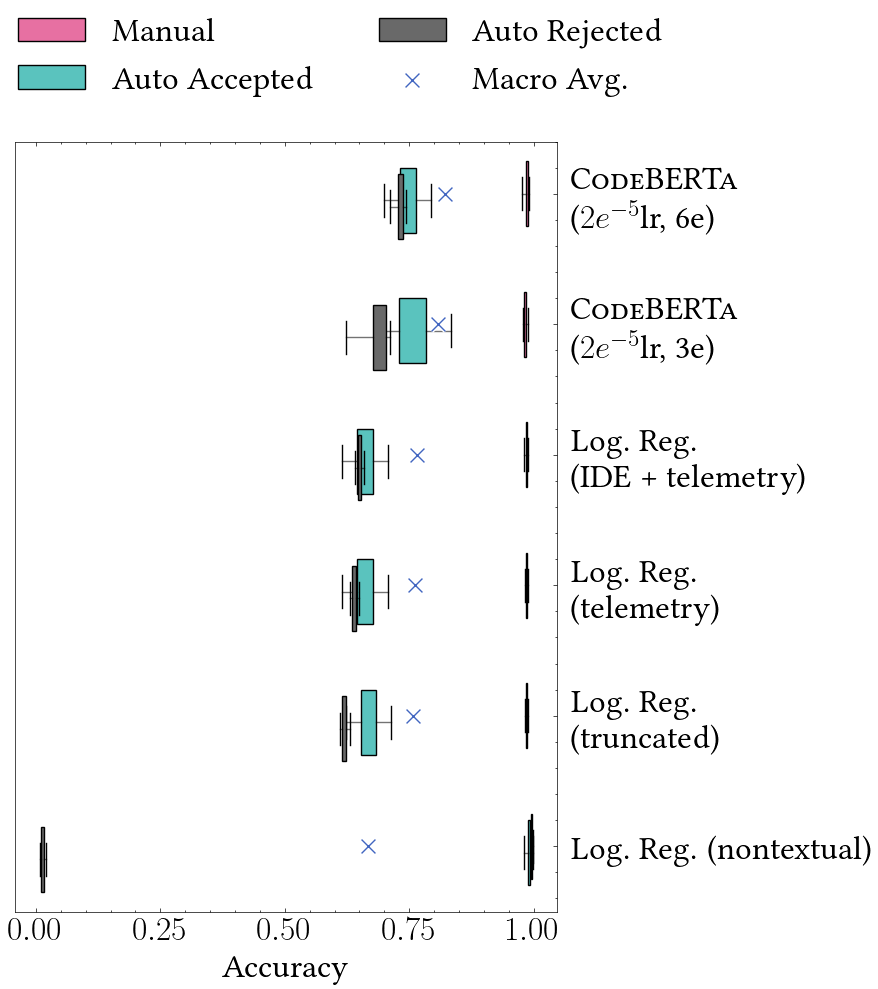

In [14]:
rq1_data.index = rq1_data.index.map(lambda x: rq1_models[x])
plot_as_bxp(rq1_data, '11_code_contribution')

In [15]:
# create a dataframe of 'macro avg' 'manual' 'auto acc' 'auto rej', 
# and convert to a latex table. 
string = rq1_data[['macro avg', 'man avg', 'auto acc avg', 'auto rej avg']]\
    .map(lambda x: 100*x if isinstance(x, float) else x) \
    .to_latex(float_format='%.1f') 

print(string)

\begin{tabular}{lrrrr}
\toprule
 & macro avg & man avg & auto acc avg & auto rej avg \\
\midrule
Log. Reg. (nontextual) & 66.7 & 99.6 & 99.1 & 1.4 \\
Log. Reg.
(truncated) & 75.8 & 98.6 & 66.8 & 61.9 \\
Log. Reg.
(telemetry) & 76.2 & 98.6 & 66.1 & 63.9 \\
Log. Reg.
(IDE + telemetry) & 76.5 & 98.5 & 66.1 & 65.0 \\
\textsc{CodeBERTa}
($2e^{-5}$lr, 3e) & 80.7 & 98.3 & 75.7 & 68.2 \\
\textsc{CodeBERTa}
($2e^{-5}$lr, 6e) & 82.1 & 98.5 & 74.7 & 73.1 \\
\bottomrule
\end{tabular}



#### RQ2: Integrating Telemetry Features into RoBERTa
Top-performing JonBERTa-Head, -Attn, and CodeBERTa. 

In [32]:
# jonberta_h_ft = jonberta_h[jonberta_h.index.str.contains('HEAD')]
# jonberta_a_ft = agg_df[agg_df.index.str.contains('ATTN')]

jonberta_h[jonberta_h.index.str.contains('CodeBERTa-small-v1')][cols]

,man avg,auto acc avg,auto rej avg,total avg,macro avg
13_jonberta-biased-CodeBERTa-small-v1-(HEAD---)-2e-05lr-,0.982371,0.744144,0.703255,0.780139,0.809923
13_jonberta-biased-CodeBERTa-small-v1-(HEAD---reinit)-2e-05lr-,0.982020,0.745084,0.703843,0.780478,0.810316


/var/folders/vv/7p5032fj2670000xcyxd84q00000gn/T/ipykernel_78300/3490408628.py:41: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  handle_macro_avg = ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=10, edgecolor='black', linewidth=1)
/var/folders/vv/7p5032fj2670000xcyxd84q00000gn/T/ipykernel_78300/3490408628.py:42: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=9, color='white', edgecolor='white', linewidth=3)


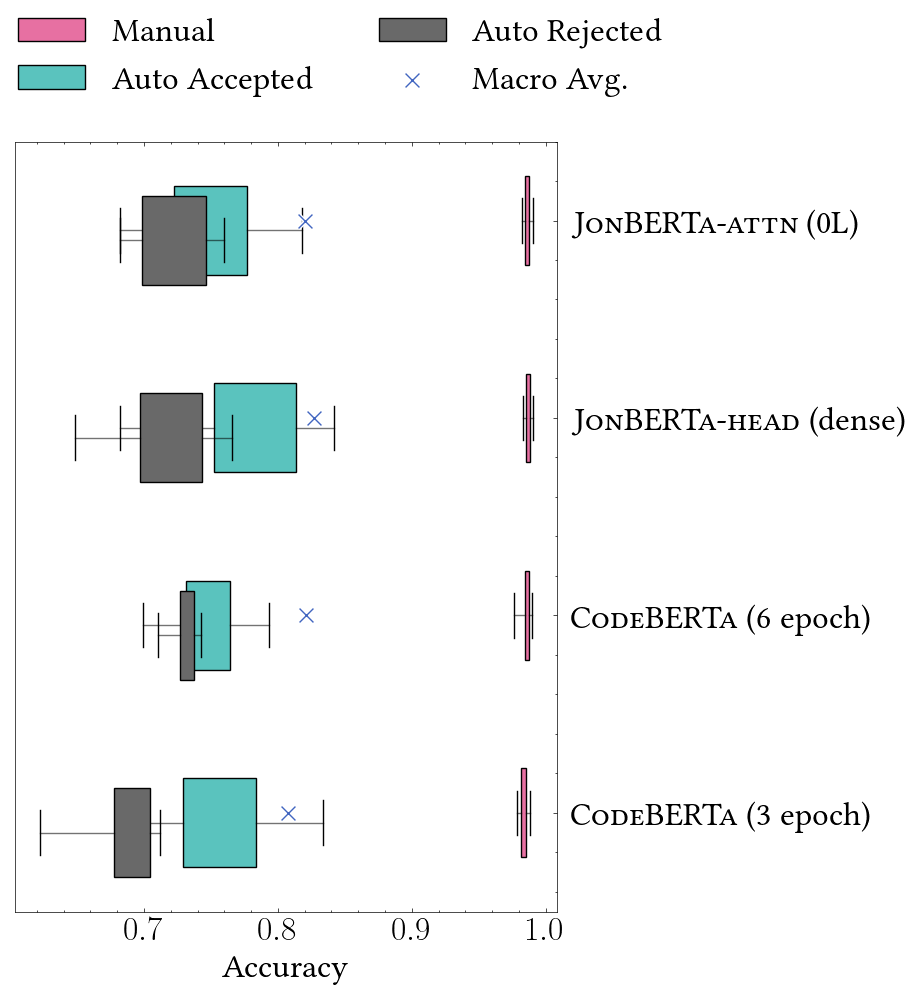

In [33]:
rq2_models = {
    '12_codeberta-biased-2e-05lr-':         
        r'\textsc{CodeBERTa} (3 epoch)',
    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD---)-2e-05lr':
        r'\textsc{CodeBERTa} (6 epoch)',
    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD-dense--reinit)-2e-05lr':
        r'\textsc{JonBERTa-head} (dense)', # NOTE: this is also the re-initialised head 
    '13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0]L)-2e-05lr-':
        r'\textsc{JonBERTa-attn} (0L)', 
}

pd.concat([
    jonberta_h.sort_values('macro avg').tail(1),
    jonberta_a.sort_values('macro avg').tail(1),
    codeberta.sort_values('macro avg') .tail(1), 
]).sort_values('macro avg')

rq2_data = agg_df.T[rq2_models.keys()].T
rq2_data.index = rq2_data.index.map(lambda x: rq2_models[x])
rq2_data[cols]
plot_as_bxp(rq2_data, '11_code_contribution')

In [34]:
# create a dataframe of 'macro avg' 'manual' 'auto acc' 'auto rej', 
# and convert to a latex table. 
string = rq2_data[['macro avg', 'man avg', 'auto acc avg', 'auto rej avg']]\
    .map(lambda x: 100*x if isinstance(x, float) else x) \
    .to_latex(float_format='%.1f') 

print(string)

\begin{tabular}{lrrrr}
\toprule
 & macro avg & man avg & auto acc avg & auto rej avg \\
\midrule
\textsc{CodeBERTa} (3 epoch) & 80.7 & 98.3 & 75.7 & 68.2 \\
\textsc{CodeBERTa} (6 epoch) & 82.1 & 98.5 & 74.7 & 73.1 \\
\textsc{JonBERTa-head} (dense) & 82.7 & 98.6 & 78.0 & 71.4 \\
\textsc{JonBERTa-attn} (0L) & 82.0 & 98.6 & 75.0 & 72.5 \\
\bottomrule
\end{tabular}



In [36]:
rq2_table = get_tabel(rq2_data)
# rq2_table.index = rq2_table.index.map(lambda x: rq2_models[x])
print(rq2_table.to_latex())

\begin{tabular}{llllll}
\toprule
 & man & auto acc & auto rej & total & macro avg \\
\midrule
\textsc{CodeBERTa} (3 epoch) & 98.3 $\pm$ 0.5 & 75.7 $\pm$ 7.6 & 68.2 $\pm$ 3.0 & 76.5 $\pm$ 2.1 & 80.7 \\
\textsc{CodeBERTa} (6 epoch) & 98.5 $\pm$ 0.4 & 74.7 $\pm$ 4.6 & 73.1 $\pm$ 1.2 & 80.0 $\pm$ 0.9 & 82.1 \\
\textsc{JonBERTa-head} (dense) & 98.6 $\pm$ 0.4 & 78.0 $\pm$ 6.2 & 71.4 $\pm$ 5.1 & 79.0 $\pm$ 3.5 & 82.7 \\
\textsc{JonBERTa-attn} (0L) & 98.6 $\pm$ 0.4 & 75.0 $\pm$ 6.8 & 72.5 $\pm$ 3.5 & 79.7 $\pm$ 2.4 & 82.0 \\
\bottomrule
\end{tabular}



In [36]:
jonberta_a.sort_values('macro avg')[['macro avg']][-20:]

,macro avg
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[1, 2, 3]L)-2e-05lr",0.820268
13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0]L)-2e-05lr-,0.820296
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 3]L)-2e-05lr",0.820475
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 1]L)-2e-05lr",0.820497
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 2, 5]L)-2e-05lr",0.820549
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 3, 5]L)-2e-05lr",0.820661
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 3, 5]L)-2e-05lr",0.820731
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 2]L)-2e-05lr",0.820764
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 4, 5]L)-2e-05lr",0.820913
"-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[3, 5]L)-2e-05lr",0.821072


In [17]:
index_map = {
    '-11_logres-biased-tr_copilot': 
        r'Log. Reg. (minimal telemetry)', 

    '-11_logres-biased-copilot': 
        r'Log. Reg. (telemetry)',

    '-11_logres-biased-ide_and_copilot': 
        r'Log. Reg. (IDE + telemetry)',

    '12_codeberta-biased-1e-05lr-': 
        r"\textsc{CodeBERTa} ($1e^{-5}$lr)", 

    '12_codeberta-biased-2e-05lr-': 
        r'\textsc{CodeBERTa} ($2e^{-5}$lr)',

    '12_codeberta-biased-5e-05lr-': 
        r'\textsc{CodeBERTa} ($5e^{-5}$lr)',

    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD-dense--)-2e-05lr': 
        r'\textsc{JonBERTa-head} (dense)',

    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[2, 3, 4]L)-2e-05lr': 
        r'\textsc{JonBERTa-attn} ([2,3,4]L)',

    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[0, 1, 4]L)-2e-05lr': 
        r'\textsc{JonBERTa-attn} ([0,1,4]L)',

    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(ATTN-208C_f-[4, 5]L)-2e-05lr': 
        r'\textsc{JonBERTa-attn} ([4,5]L)',

    '-13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD-dense--reinit)-2e-05lr': 
        r'\textsc{JonBERTa-head} (dense, reinit)',

    '13_jonberta-biased-12_codeberta-biased-2e-05lr--0-(HEAD--proj-reinit)-2e-05lr-':
        r'\textsc{JonBERTa-head} (proj)',
}

data.index = data.index.map(lambda x: index_map[x])

In [12]:
data

,total avg,total std,total min,total max,total med,total 25,total 75,total 95,total 5,total 2.5,...,auto rej min,auto rej max,auto rej med,auto rej 25,auto rej 75,auto rej 95,auto rej 5,auto rej 2.5,auto rej 97.5,macro avg
Log. Reg. (minimal telemetry),0.725608,0.002975,0.715171,0.736117,0.725599,0.723594,0.727616,0.730502,0.720652,0.719672,...,0.613502,0.640028,0.627007,0.624393,0.629647,0.633296,0.620652,0.619454,0.634440,0.758889
Log. Reg. (telemetry),0.737715,0.002933,0.726134,0.749086,0.737744,0.735761,0.739683,0.742535,0.732864,0.731928,...,0.629477,0.658810,0.644060,0.641488,0.646586,0.650240,0.637751,0.636501,0.651348,0.762487
Log. Reg. (IDE + telemetry),0.744398,0.002895,0.732240,0.754746,0.744407,0.742446,0.746323,0.749133,0.739594,0.738702,...,0.639741,0.667172,0.654399,0.651819,0.656856,0.660426,0.648084,0.647014,0.661546,0.763680
\textsc{CodeBERTa} ($1e^{-5}$lr),0.751609,0.022657,0.705321,0.789063,0.757643,0.734379,0.769855,0.781353,0.714680,0.713254,...,0.599219,0.718206,0.671734,0.638409,0.689928,0.708442,0.611468,0.609634,0.710182,0.794460
\textsc{CodeBERTa} ($5e^{-5}$lr),0.740708,0.032303,0.693556,0.795035,0.740128,0.706614,0.769364,0.786879,0.701266,0.700018,...,0.579435,0.724534,0.644306,0.596003,0.693270,0.714511,0.588701,0.587118,0.716347,0.801758
\textsc{CodeBERTa} ($2e^{-5}$lr),0.765488,0.020003,0.716820,0.792361,0.771593,0.762991,0.780239,0.785632,0.726001,0.724707,...,0.612634,0.718703,0.691451,0.677411,0.704227,0.710189,0.623794,0.622096,0.711639,0.807476
\textsc{JonBERTa}-H,0.790115,0.018291,0.755014,0.812461,0.800874,0.766512,0.803860,0.807113,0.761610,0.760406,...,0.664297,0.746033,0.731024,0.679819,0.734879,0.739076,0.673346,0.671804,0.740247,0.823593
"\textsc{JonBERTa}-A ([2,3,4]L)",0.806218,0.006444,0.788127,0.821553,0.808183,0.799848,0.811258,0.814647,0.795303,0.794233,...,0.713893,0.761435,0.741991,0.728472,0.746447,0.751183,0.722484,0.721167,0.752428,0.824991
"\textsc{JonBERTa}-A ([0,1,4]L)",0.797495,0.012528,0.775693,0.824405,0.793921,0.786434,0.812149,0.816606,0.781754,0.780640,...,0.693026,0.763252,0.722295,0.708485,0.748026,0.753915,0.702291,0.700815,0.755181,0.825094
"\textsc{JonBERTa}-A ([4,5]L)",0.802198,0.012559,0.783002,0.828416,0.795681,0.792539,0.817720,0.822177,0.789063,0.788038,...,0.706485,0.770931,0.722224,0.718218,0.756759,0.762585,0.713600,0.712273,0.764054,0.826225


/var/folders/vv/7p5032fj2670000xcyxd84q00000gn/T/ipykernel_56074/3015568897.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  handle_macro_avg = ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=10, edgecolor='black', linewidth=1)
/var/folders/vv/7p5032fj2670000xcyxd84q00000gn/T/ipykernel_56074/3015568897.py:41: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=9, color='white', edgecolor='white', linewidth=3)


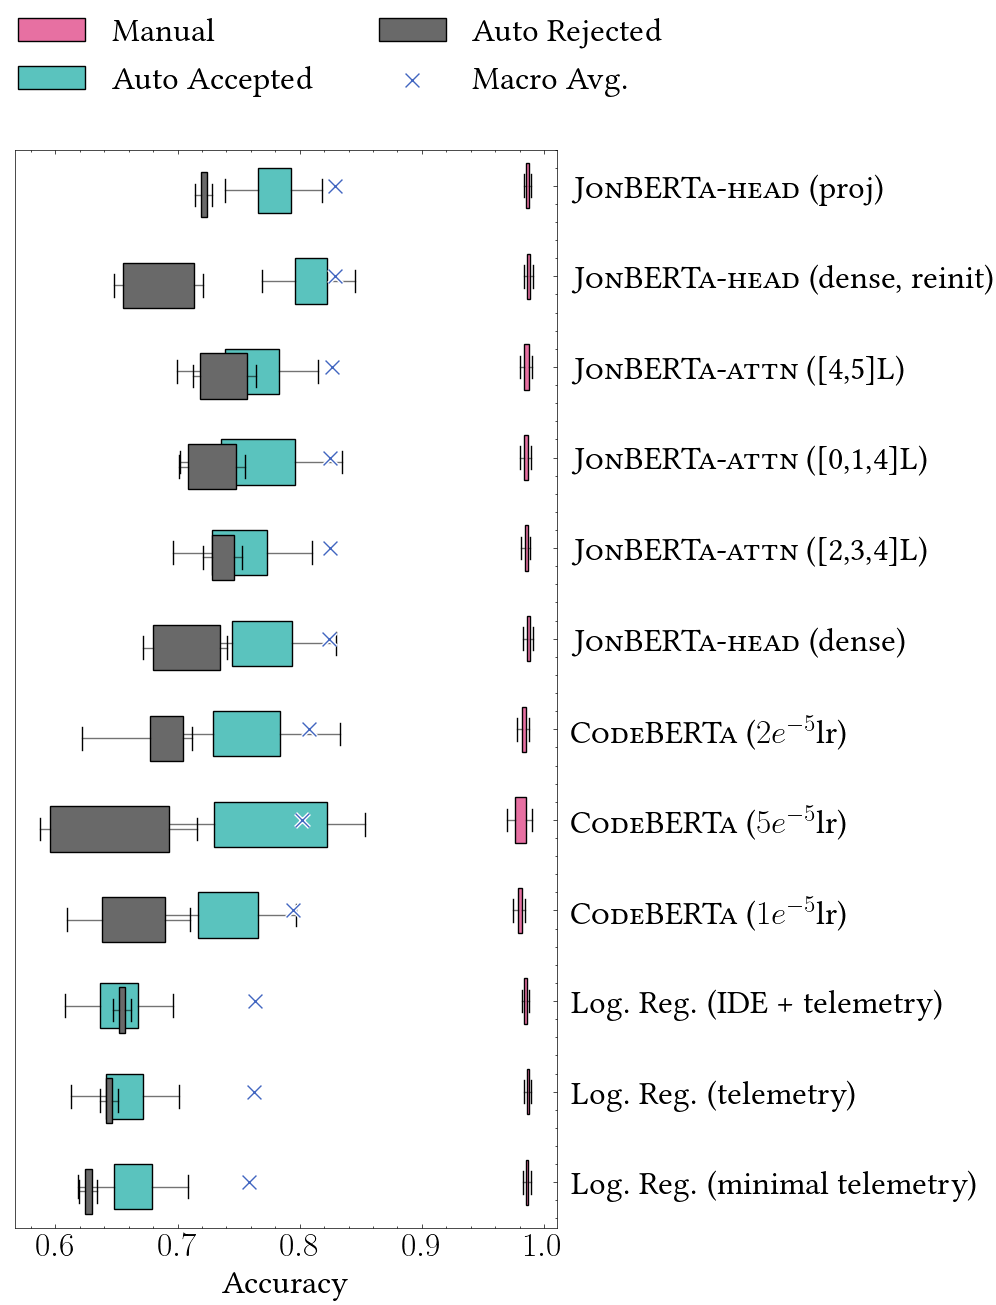

Log. Reg. (minimal telemetry)             0.758889
Log. Reg. (telemetry)                     0.762487
Log. Reg. (IDE + telemetry)               0.763680
\textsc{CodeBERTa} ($1e^{-5}$lr)          0.794460
\textsc{CodeBERTa} ($5e^{-5}$lr)          0.801758
\textsc{CodeBERTa} ($2e^{-5}$lr)          0.807476
\textsc{JonBERTa-head} (dense)            0.823593
\textsc{JonBERTa-attn} ([2,3,4]L)         0.824991
\textsc{JonBERTa-attn} ([0,1,4]L)         0.825094
\textsc{JonBERTa-attn} ([4,5]L)           0.826225
\textsc{JonBERTa-head} (dense, reinit)    0.828593
\textsc{JonBERTa-head} (proj)             0.829195
Name: macro avg, dtype: float64

In [18]:
def get_stats(data: pd.DataFrame, label: str): 
    return [
        {
            # 'label':  '',
            'med':    row[f'{label} med'],
            'q1' :    row[f'{label} 25'],
            'q3' :    row[f'{label} 75'],
            'whislo': row[f'{label} 2.5'],
            'whishi': row[f'{label} 97.5'],
            'fliers': []
        } for model, row in data.iterrows()
    ] 

# TODO: Set figsize width to \textwidth
fig, ax = plt.subplots(1, 1, figsize=(7, 14))
ax : plt.axes = ax 

prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# prop_cycle = prop_cycle[1:]

labels = {'man': 'Manual', 'auto acc': 'Auto Accepted', 'auto rej': 'Auto Rejected'}
kwargs = lambda c: dict(
    vert=False, 
    positions=[i - 0.05*c for i in range(12)],
    patch_artist=True, 
    # set box fill to be c, but maintain black borders 
    boxprops=dict(edgecolor='black', facecolor=prop_cycle[c + 1]),
    # also set the medians to be alpha 0 
    medianprops=dict(color='black', alpha=0),
    # set whiskers to 0.95 alpha 
    whiskerprops=dict(color='black', alpha=0.55),
)

# plot as above, but nudge each one slightly vertically to avoid overlap
handle_man = ax.bxp(get_stats(data, 'man'), **kwargs(0))
handle_auto_acc = ax.bxp(get_stats(data, 'auto acc'), **kwargs(1))
handle_auto_rej = ax.bxp(get_stats(data, 'auto rej'), **kwargs(2))
# handle_macro_avg = ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100)
# handle-macro-avg but with z order set to top and a white border around each check of width 3 
handle_macro_avg = ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=10, edgecolor='black', linewidth=1)
ax.scatter(data['macro avg'].tolist(), data.index.tolist(), marker='x', s=100, zorder=9, color='white', edgecolor='white', linewidth=3)


# bxp creates new labels for every item in the list, but we want only one label per boxplot
# so we need to set the labels manually 
ax.set_yticks(range(12))
ax.set_yticklabels(data.index)
ax.yaxis.tick_right()
# pad the y tick labels 
ax.tick_params(axis='y', pad=10)

ax.set_xlabel('Accuracy')

# MANUALLY set the legend
import matplotlib
ax.legend(
    [matplotlib.patches.Patch(facecolor=c, edgecolor='black') for c in prop_cycle[1:4]] + [handle_macro_avg],
    ['Manual', 'Auto Accepted', 'Auto Rejected', 'Macro Avg.'],
    loc='upper center', bbox_to_anchor=(0.6, 1.15), ncol=2
)


plt.show()
fig.savefig(os.path.join(images_dir, '13_model_accuracies.pdf'))
data['macro avg']

#### Appendix

In [27]:
# get only those rows with 'ide_and_copilot' in the index 
agg_df[agg_df.index.str.contains('ide_and_copilot')][cols].map(lambda x: f'{100*x:.1f}')

,man avg,auto acc avg,auto rej avg,total avg,macro avg
-11_logres-unbalanced-ide_and_copilot,97.4,0.0,99.8,97.3,65.8
-11_logres-classes-ide_and_copilot,97.8,0.0,99.7,97.3,65.8
-11_logres-subclasses-ide_and_copilot,97.8,35.7,88.4,90.0,74.0
-11_logres-biased-ide_and_copilot,98.5,66.1,65.0,74.2,76.5


#### Appendix: Jonberta-Head

In [11]:
table = get_tabel(jonberta_h.sort_values('macro avg', ascending=False)).drop('total', axis=1)
table.index = table.index.map(lambda x: x[x.find('(')+1:x.find(')')])

# drop the 'total' 
print(table.to_latex())

\begin{tabular}{lllll}
\toprule
 & man & auto acc & auto rej & macro avg \\
\midrule
HEAD-dense--reinit & 98.6 $\pm$ 0.4 & 78.0 $\pm$ 6.2 & 71.4 $\pm$ 5.1 & 82.7 \\
HEAD--proj-reinit & 98.6 $\pm$ 0.6 & 76.1 $\pm$ 11.0 & 72.4 $\pm$ 3.6 & 82.3 \\
HEAD-dense-- & 98.6 $\pm$ 0.5 & 75.6 $\pm$ 6.8 & 72.6 $\pm$ 4.4 & 82.3 \\
HEAD--- & 98.5 $\pm$ 0.4 & 74.7 $\pm$ 4.6 & 73.1 $\pm$ 1.2 & 82.1 \\
HEAD-dense-proj- & 98.6 $\pm$ 0.3 & 73.5 $\pm$ 6.7 & 74.1 $\pm$ 1.8 & 82.1 \\
HEAD-dense-proj-reinit & 98.5 $\pm$ 0.5 & 72.2 $\pm$ 5.8 & 75.4 $\pm$ 1.9 & 82.0 \\
HEAD--proj- & 98.4 $\pm$ 0.5 & 72.9 $\pm$ 7.0 & 74.7 $\pm$ 5.0 & 82.0 \\
HEAD---reinit & 98.5 $\pm$ 0.4 & 74.3 $\pm$ 5.1 & 73.1 $\pm$ 1.2 & 82.0 \\
HEAD---reinit & 98.2 $\pm$ 0.5 & 74.5 $\pm$ 6.8 & 70.4 $\pm$ 3.4 & 81.0 \\
HEAD--- & 98.2 $\pm$ 0.5 & 74.4 $\pm$ 8.1 & 70.3 $\pm$ 3.4 & 81.0 \\
\bottomrule
\end{tabular}



#### Appendix: Jonberta-Attn

In [24]:
table = get_tabel(jonberta_a.sort_values('macro avg', ascending=False)).drop('total', axis=1)
table.index = table.index.map(lambda x: x[x.find('biased-')+len('biased-'):x.find(')')])

ft_from_12 = table[table.index.str.contains('12_codeberta')]
ft_from_scratch = table[~table.index.str.contains('12_codeberta')]

In [34]:
ft_table = ft_from_scratch.copy()

ft_table.index = ft_table.index \
    .map(lambda x: x[x.find('ATTN-')+len('ATTN-'):]) \
    .map(lambda x: x.replace('208C_f-', ' '))
print(ft_table.to_latex())

\begin{tabular}{lllll}
\toprule
 & man & auto acc & auto rej & macro avg \\
\midrule
 [1, 4, 5]L & 98.4 $\pm$ 0.4 & 75.9 $\pm$ 6.4 & 69.9 $\pm$ 5.8 & 81.4 \\
 [2, 4, 5]L & 98.4 $\pm$ 0.5 & 77.1 $\pm$ 6.9 & 68.5 $\pm$ 6.4 & 81.3 \\
 [0, 4, 5]L & 98.2 $\pm$ 0.7 & 76.4 $\pm$ 8.0 & 69.1 $\pm$ 5.0 & 81.3 \\
 [0, 1, 4]L & 98.3 $\pm$ 0.4 & 77.3 $\pm$ 5.8 & 68.1 $\pm$ 2.7 & 81.2 \\
 [0, 1, 5]L & 98.3 $\pm$ 0.4 & 77.3 $\pm$ 5.0 & 68.1 $\pm$ 2.8 & 81.2 \\
 [0, 2, 4]L & 98.3 $\pm$ 0.7 & 77.5 $\pm$ 7.1 & 67.9 $\pm$ 5.6 & 81.2 \\
 [1, 2, 3]L & 98.2 $\pm$ 0.5 & 77.6 $\pm$ 5.0 & 67.9 $\pm$ 2.1 & 81.2 \\
 [0, 1, 3]L & 98.4 $\pm$ 0.4 & 78.0 $\pm$ 6.1 & 67.2 $\pm$ 6.1 & 81.2 \\
 [3, 4, 5]L & 98.4 $\pm$ 0.5 & 76.3 $\pm$ 6.2 & 68.7 $\pm$ 3.3 & 81.1 \\
 [0, 2, 5]L & 98.3 $\pm$ 0.4 & 77.4 $\pm$ 5.8 & 67.6 $\pm$ 3.1 & 81.1 \\
 [1, 2, 4]L & 98.4 $\pm$ 0.5 & 77.3 $\pm$ 7.0 & 67.6 $\pm$ 5.0 & 81.1 \\
 [0, 1, 2]L & 98.5 $\pm$ 0.6 & 80.6 $\pm$ 5.2 & 64.1 $\pm$ 6.2 & 81.1 \\
 [0, 3, 5]L & 98.3 $\pm$ 0.5 & 76.0 $\p

In [35]:
table_12 = ft_from_12.copy()
table_12.index = table_12.index \
    .map(lambda x: x[x.find('['):x.find(')')])

print(table_12.to_latex())

\begin{tabular}{lllll}
\toprule
 & man & auto acc & auto rej & macro avg \\
\midrule
[4, 5] & 98.6 $\pm$ 0.5 & 76.6 $\pm$ 5.7 & 72.1 $\pm$ 4.2 & 82.4 \\
[2, 3, 4] & 98.5 $\pm$ 0.4 & 74.8 $\pm$ 5.9 & 73.8 $\pm$ 2.4 & 82.4 \\
[0, 1, 4] & 98.5 $\pm$ 0.4 & 75.2 $\pm$ 7.6 & 73.1 $\pm$ 4.1 & 82.3 \\
[0, 1, 3] & 98.5 $\pm$ 0.4 & 74.8 $\pm$ 4.6 & 73.4 $\pm$ 2.0 & 82.3 \\
[2, 5] & 98.5 $\pm$ 0.4 & 74.9 $\pm$ 4.6 & 73.2 $\pm$ 3.0 & 82.2 \\
[0, 5] & 98.6 $\pm$ 0.3 & 74.6 $\pm$ 7.5 & 73.3 $\pm$ 6.1 & 82.2 \\
[1, 2, 5] & 98.6 $\pm$ 0.3 & 75.5 $\pm$ 7.2 & 72.4 $\pm$ 2.7 & 82.2 \\
[2] & 98.6 $\pm$ 0.4 & 75.8 $\pm$ 5.9 & 71.9 $\pm$ 3.1 & 82.1 \\
[3, 4] & 98.6 $\pm$ 0.4 & 75.7 $\pm$ 5.3 & 72.0 $\pm$ 2.5 & 82.1 \\
[3, 4, 5] & 98.4 $\pm$ 0.4 & 74.4 $\pm$ 5.0 & 73.5 $\pm$ 2.3 & 82.1 \\
[3, 5] & 98.5 $\pm$ 0.3 & 74.2 $\pm$ 6.3 & 73.6 $\pm$ 2.7 & 82.1 \\
[0, 4, 5] & 98.5 $\pm$ 0.4 & 75.0 $\pm$ 4.9 & 72.8 $\pm$ 2.3 & 82.1 \\
[0, 2] & 98.7 $\pm$ 0.3 & 77.5 $\pm$ 4.6 & 70.1 $\pm$ 1.9 & 82.1 \\
[0, 3, 5] & 98.6